<img src="./logo_UNSAM.jpg" align="right" width="150" />

# Tarea semanal 9
#### Análisis y procesaimento de señales
**Kala Ariadna Guevara, Carola Piazze Vicini** 

## Introducción
En este trabajo analizamos métodos de procesamiento digital aplicados a señales ECG con el objetivo de estimar la línea de base, y corregir parte del ruido del ecg eliminando esa linea de base. Para eso usamos filtros de mediana e interpolación mediante splines cúbicos. También nos familiarizamos brevemente con los conceptos de filtro adaptado.



#### Filtro de mediana
En este trabajo se aplica un filtro de mediana en dos etapas para eliminar la deriva de línea de base en señales ECG. Primero, se suaviza la señal con una ventana de 201 muestras para reducir el ruido de alta frecuencia. Luego, se aplica un segundo filtro de mediana con ventana de 601 muestras sobre el resultado anterior, obteniendo una estimación de la componente de baja frecuencia (línea de base). Al sustraer esta línea de base de la señal original, se obtiene una versión filtrada del ECG con las ondas principales (QRS, P, F) realzadas y la deriva eliminada, facilitando su análisis clínico.


Text(0.5, 1.0, 'Tramo sin ruido')

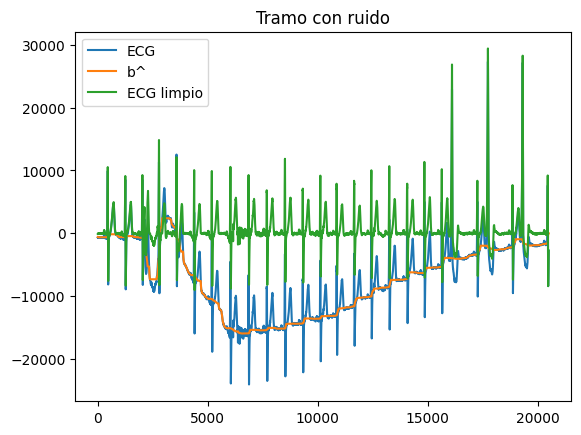

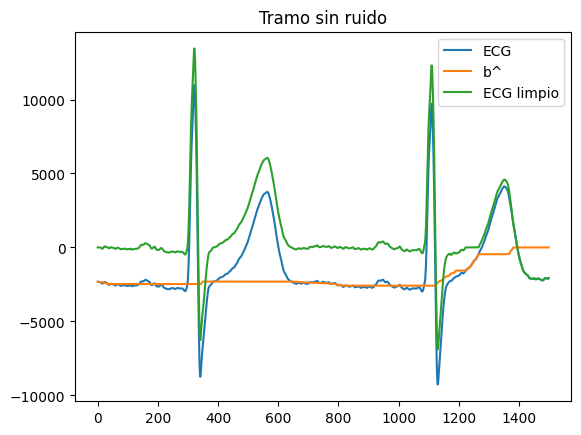

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal 
import scipy.io as sio
from scipy.interpolate import CubicSpline

## 1. Mediana
# b^ La idea es que el soporte del filtro me saque el ECG para estimar las bajas frecuencias - linea de base
# la med(s) de 200 se saca de encima el complejo QRS y el de 600 las ondas p y f


sio.whosmat('ecg.mat')
mat_struct = sio.loadmat('./ecg.mat')
ecg_one_lead = mat_struct['ecg_lead'].flatten()
#qrst detenctions, calcular cuanto me tengo que mover desde la linea roja hasta la zona de deteccion

 #Tramo con Ruido
ECG=ecg_one_lead [100000: 120500]


med200=signal.medfilt(ECG, 201)
med600=signal.medfilt(med200, 601) #b

ECG_limpio=ECG-med600

plt.figure()
plt.plot(ECG, label='ECG')
plt.plot(med600, label='b^')
plt.plot(ECG_limpio, label='ECG limpio')
plt.legend()
plt.title("Tramo con ruido")

#Tramo sin Ruido
ECG=ecg_one_lead [4000: 5500] 


med200=signal.medfilt(ECG, 201)
med600=signal.medfilt(med200, 601) #b

ECG_limpio=ECG-med600

plt.figure()
plt.plot(ECG, label='ECG')
plt.plot(med600, label='b^')
plt.plot(ECG_limpio, label='ECG limpio')
plt.legend()
plt.title("Tramo sin ruido")

#### Spline Cúbico
Luego utilizamos el spline cúbico, otra estrategia para eliminar la deriva de línea de base en señales ECG que consiste en ajustar una curva suave que interpole puntos representativos del componente lento. Seleccionamos muestras ubicadas aproximadamente en el valle entre las ondas P y Q ya que allí debería haber cero energía, sin embargo se observa que hay variaciones generadas por el ruido. Para ubicar estos valles desplazamos cada valor del vector qrs_detections 80 muestras hacia atrás.
Estos puntos (sx) se consideran representativos de la línea de base, y sus valores (sy) se extraen directamente de la señal original.
A partir de estos puntos, se construye una interpolación por spline cúbico, que genera una función continua y suavemente derivable que atraviesa todos los puntos seleccionados. Esta función se evalúa sobre toda la longitud de la señal, generando una estimación de la línea de base (b). Finalmente, se sustrae esta curva de la señal original, obteniendo un ECG filtrado con la deriva eliminada y las componentes rápidas preservadas.


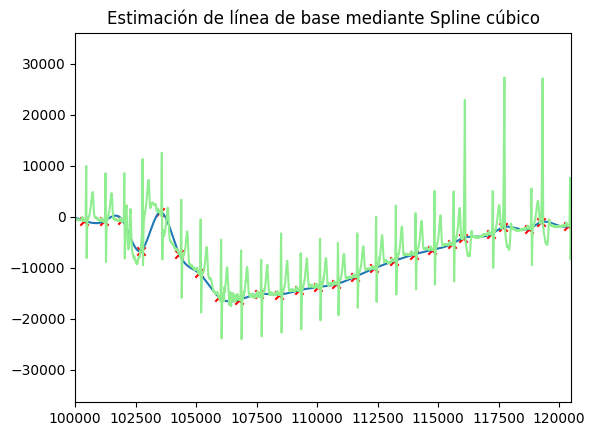

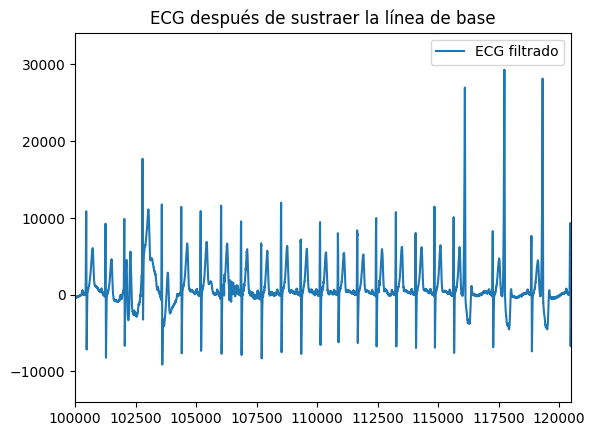

In [7]:
################
#SPLINE CÚBICO
################ 

## 2. Splines Cubicos
# la funcion interpolante es suave, C3. 
# Puntos de referencia, segmentos isoelectricos

#si sumo muestras tengo un pasabajo ??

#class CubicSpline(x, y, axis=0, bc_type='not-a-knot', extrapolate=None)[source]
#el cubicspline no devuelve una variable devuelve objetos, son instancias ??que tiene distintos operadores? que hacen cosas. me devuelve une 
#referencia al objeto


maximos= mat_struct['qrs_detections']
#leresto 80 muestras a ojo, viendo el gráfico del ecg
vector_max=maximos-80 #ahora tengo todos los valores e el medio de ese valle entre p y q

#implementación


ECG = ecg_one_lead 
N=len(ECG)
sx=vector_max.flatten()
sy=ECG[sx]


cs=CubicSpline(sx,sy)
n = np.arange(N)
b=cs(n)

ecg_limpio= ECG-b

plt.figure()
plt.scatter(sx,sy,color='red',marker='x')
plt.plot(b,label='b, cubic spline')
plt.plot(ECG, color='lightgreen',label='ecg')
plt.xlim(100000, 120500)
plt.title("Estimación de línea de base mediante Spline cúbico")
plt.show()

plt.figure()
plt.plot(ecg_limpio, label='ECG filtrado')
plt.xlim(100000, 120500)
plt.legend()
plt.title("ECG después de sustraer la línea de base")
plt.show()

### Filtro adaptado, máximos del ecg
Para detectar los complejos QRS se aplicó un filtro adaptado, cuya función es maximizar la relación señal-ruido cuando se busca un patrón conocido dentro de una señal con ruido. Un filtro adaptado implementa la correlación entre la señal de ECG y el patrón provisto en qrs_pattern1; en la práctica, esto se obtiene convolucionando el ECG con una versión invertida temporalmente del patrón. Cuando la morfología del ECG coincide con el patrón, la salida del filtro presenta picos pronunciados.
El detector se basa en que cada latido real produce una elevada correlación con el patrón, por lo que basta identificar los máximos locales de la salida del filtro para estimar los instantes de QRS. Una de las limitaciones es que el filtro introduce un retardo, que en este caso corregimos manualmente.
También desarrollamos un bucle que recorre cada detección y busca si cae cerca de algún latido real, en caso afirmativo los identificamos como True Positive (TP) y en el contrario como False Positives (FP). Se encontraron 1902 TP y 2 FP, por lo que podemos concluir que el método funcionó casi a la perfección.

C:\Users\Carola\pepe\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


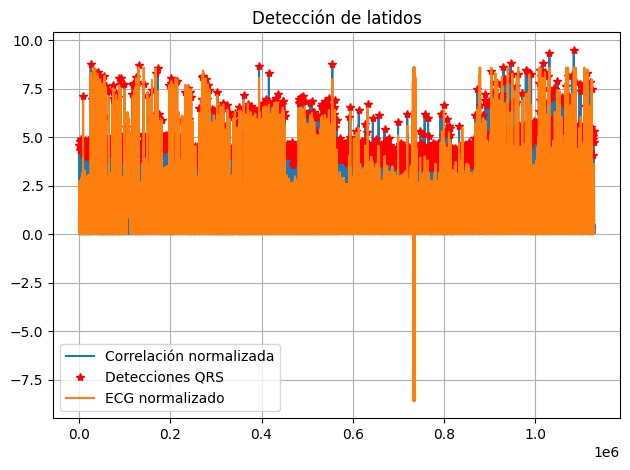

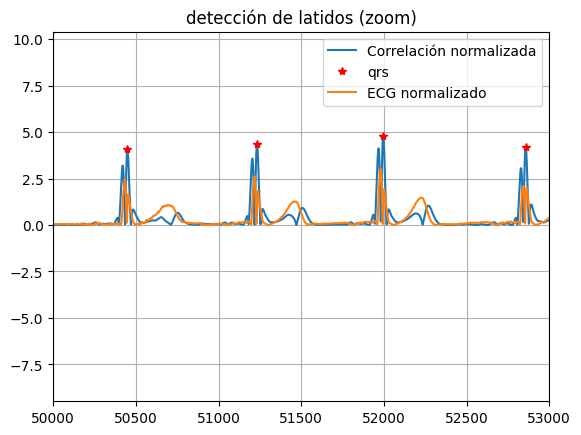

TP: 1902
FP: 3


In [8]:
##########
#ADAPTADO
##########
#cargo patron
qrs_pattern1= mat_struct['qrs_pattern1'] #el patron que nos dieron
pattern2= qrs_pattern1.flatten() - np.mean(qrs_pattern1) #centro para poder correlar

#correlación con ltfilter
ecg_detection=signal.lfilter(b=pattern2,a=1, x=ecg_one_lead)

ecg_detection_abs=np.abs(ecg_detection)[50:] #descarto muestras por delay, aplico modulo
ecg_detection_norm = ecg_detection_abs/np.std(ecg_detection_abs) #normalizo

#detección de picos
qrs, _ = signal.find_peaks(ecg_detection_norm, height=1, distance=300)

#normalizo para graficar junto al detector
ecg_one_lead_abs=np.abs(ecg_one_lead)
ecg_one_lead_norm=ecg_one_lead_abs/np.std(ecg_one_lead_abs)

plt.figure()
plt.plot(ecg_detection_norm, label='Correlación normalizada')
plt.plot(qrs, ecg_detection_norm[qrs], 'r*', label='Detecciones QRS')
plt.plot(ecg_one_lead_norm, label='ECG normalizado')
plt.title('Detección de latidos')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#le hago un poco de zoom
plt.figure()
plt.plot(ecg_detection_norm, label='Correlación normalizada')
plt.plot(qrs, ecg_detection_norm[qrs], 'r*',label='qrs')
plt.plot(ecg_one_lead_norm, label='ECG normalizado')

plt.xlim(50000, 53000)   

plt.title('detección de latidos (zoom)')
plt.legend()
plt.grid(True)
plt.show()

tol = 50  # tolerancia en muestras
TP = 0 #true positives
FP = 0 #fake positives

ref_used = np.zeros(len(maximos))

for d in qrs:
    encontrado = False
    for i, r in enumerate(maximos):
        if ref_used[i] == 0 and abs(d - r) <= tol:
            TP += 1
            ref_used[i] = 1
            encontrado = True
            break
    if not encontrado:
        FP += 1

print("TP:", TP)
print("FP:", FP)


### Conclusiones
Este trabajo resultó interesante porque al resolver y discutir la mayoría delos temas en clase, tuvimos bastante claro desde el principio lo que había que hacer, y qué fenómenos observar. Tanto el filtro de mediana como el de spline cúbico hicieron un buen trabajo eliminando la línea de base del ECG. El método de SPlines nos fue más familiar conceptualmente, ya que habíamos trabajado previamente con este tipo de interpoladores, pero consideramos que el filtro de mediana fue algo más prolijo en sus resultados.
El filtro adaptado fue el más ajeno, si bien se exploró brevemente el concepto en clase, consideramos que los conceptos adquiridos fueron suficientes para realizar el detector de latidos, aunque no tan profundos como para comprender en profundidad el método.

Resolvimos la tarea con seguridad.
Usamos Chat GPT muy brevemente para encontrar pequeños errores en el código, aunque fue casi innecesario ya que el código fue corroborado durante las clases.